# Traffic Flow Simulator

In [1]:
from utils import Agent, Road, Trpf, read_config
from itertools import repeat, compress
from altair import Chart
import numpy as np
import pandas as pd

## Functions

In [2]:
def get_route_choices(agents, route_count):
    choices = np.array(list(map(lambda agent: agent.choose_route(), agents)))
    route_traveller_counts = np.bincount(choices, minlength = route_count)[:, np.newaxis]
    
    return choices, route_traveller_counts

def get_route_costs(roads, choices, route_traveller_counts):
    road_traveller_counts = np.array(route_to_road * route_traveller_counts)
    list(map(lambda count, road: road.add_travellers(count), road_traveller_counts[:,0], roads))
    road_costs = np.array(list(map(lambda road: road.report_cost(), roads)))[:, np.newaxis]
    route_costs = np.array(road_to_route * road_costs)
    return route_costs

def give_costs(agents, choices, route_costs):    
    list(map(lambda agent, choice: agent.recieve_travel_cost(route_costs[choice,0]), agents, choices))
    
def get_reports(agents, trpf, choices, excess_traveller_counts):
    reports = list(map(lambda agent, choice, excess: agent.report_congestion(excess[choice,0]),\
        agents, choices, repeat(excess_traveller_counts)))
    list(map(lambda route, report: trpf.recieve_report(route, report), choices, reports))
    
def give_trpfs(trpf_agents, route_trpfs):
    list(map(lambda agent, trpf: agent.recieve_trpf(trpf), trpf_agents, repeat(route_trpfs)))

## Read the configuration

In [3]:
simulation_folder = '/home/ihsan/Research/TrafficFlowSimulator/simulations/OWNet/'
traffic_file = simulation_folder + 'traffic.properties'
roadnet_file = simulation_folder + 'roadnet.csv'

config = read_config(traffic_file, roadnet_file)

tresholds = config['tresholds']
weights = config['weights']
trpf_use_percent = config['trpf_use_percent']
t = config['t']
agent_count = config['agent_count']
change_percent = config['change_percent']
routes = config['routes']
route_opts = np.array(config['route_opts'])[:, np.newaxis]
round_count = config['round_count']
road_params = config['road_params']

## Initialize the simulation

In [4]:
route_count = len(routes)

trpf = Trpf(route_count, round_count, t)

roads = []
road_inds = {}
for i, params in enumerate(road_params.itertuples(index=False)):
    road = Road(*params)
    roads.append(road)
    road_name = params[0] + params[1] # Node 1 + Node 2
    road_inds[road_name] = i
    
agents = []
trpf_agents = []
for tag in range(agent_count):
    agent = Agent(tag, tresholds, weights, route_count, change_percent, trpf_use_percent)
    agents.append(agent)
    if agent.uses_trpf():
        trpf_agents.append(agent)

route_to_road = np.zeros((len(roads), len(routes)))
for i, route in enumerate(routes):
    for e in range(1, len(route)):
        
        try:
            road_name = route[e-1] + route[e]
            j = road_inds[road_name]
        except KeyError:
            road_name = route[e] + route[e-1]
            j = road_inds[road_name]
        
        route_to_road[j, i] = 1
        
route_to_road = np.matrix(route_to_road)
road_to_route = route_to_road.T 

data = pd.DataFrame(columns = ['Route', 'Count', 'Cost', 'Trpf', 'Round'])

print('Number of trpf users: {}, Number of routes: {}, Number of roads:{}'.format(len(trpf_agents),\
    route_count, len(roads)))

Number of trpf users: 200, Number of routes: 32, Number of roads:24


I can try addding a nice graph of the network, like the ones in the paper, here. We can also add other visualizations that describe the system we are simulating.

## Simulation

In [5]:
while trpf.start_new_round():
    choices, route_traveller_counts = get_route_choices(agents, route_count)
    excess_traveller_counts = np.absolute(route_traveller_counts - route_opts)
    
    route_costs = get_route_costs(roads, choices, route_traveller_counts)
    give_costs(agents, choices, route_costs)    
    get_reports(agents, trpf, choices, excess_traveller_counts)
    
    route_trpfs = trpf.calculate_trpf()
    give_trpfs(trpf_agents, route_trpfs)
   
    # Save the choices
    for route in range(route_count):
        route_cost = route_costs[route,0]
        route_trpf = route_trpfs[route]
        route_traveller_count = route_traveller_counts[route,0]
        
        data.loc[data.shape[0]] = [route, route_traveller_count, route_cost, route_trpf, trpf.current_round]

## Visualizations

### Statistics

In [7]:
# Drop the first 200 rounds, Trpf and Round Columns
data['TotalCost'] = data.Count * data.Cost
data_by_routes = data.drop(['Round', 'Trpf'], axis=1).groupby('Route')

means = data_by_routes.mean()
means.columns = ['CountMean', 'CostMean', 'TotalCostMean']

stds = data_by_routes.std()
stds.columns = ['CountStd', 'CostStd', 'TotalCostStd']

report = pd.concat([means, stds], axis=1)
report = report[['CountMean', 'CountStd', 'CostMean', 'CostStd', 'TotalCostMean', 'TotalCostStd']]

report

,CountMean,CountStd,CostMean,CostStd,TotalCostMean,TotalCostStd
Route,,,,,,
0.0,8.68,4.082186,36.1508,0.746306,314.9450,151.936780
1.0,2.33,2.697005,35.1810,0.544128,82.4674,96.207103
2.0,2.79,3.418000,35.3902,0.556413,99.2908,123.814426
3.0,7.88,3.334182,42.4428,0.705167,334.9674,142.217323
4.0,7.83,3.668195,41.4730,0.567948,325.8096,155.250340
5.0,7.49,2.724728,42.4852,0.561273,318.6980,117.306395
6.0,2.62,2.827641,41.5154,0.512777,109.3454,118.695351
7.0,8.19,3.523930,43.4744,0.629286,357.1890,156.877081
8.0,7.36,3.554823,33.0326,0.608875,244.2604,120.360213


### Agent Count per Route over Time

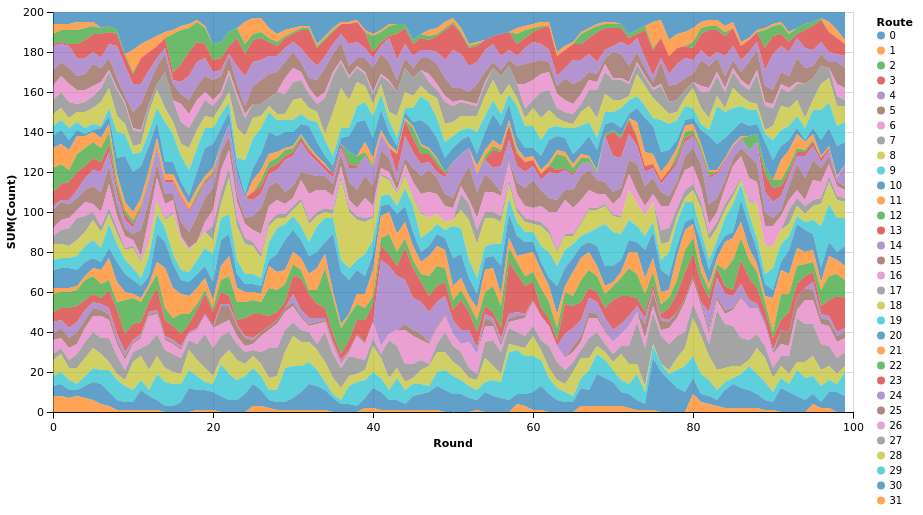

In [8]:
chart = Chart(data).mark_area().encode(x='Round:Q', y='sum(Count):Q', color='Route:N')
chart.configure_cell(height=400, width=800)

### Cost per Agent per Route over Time

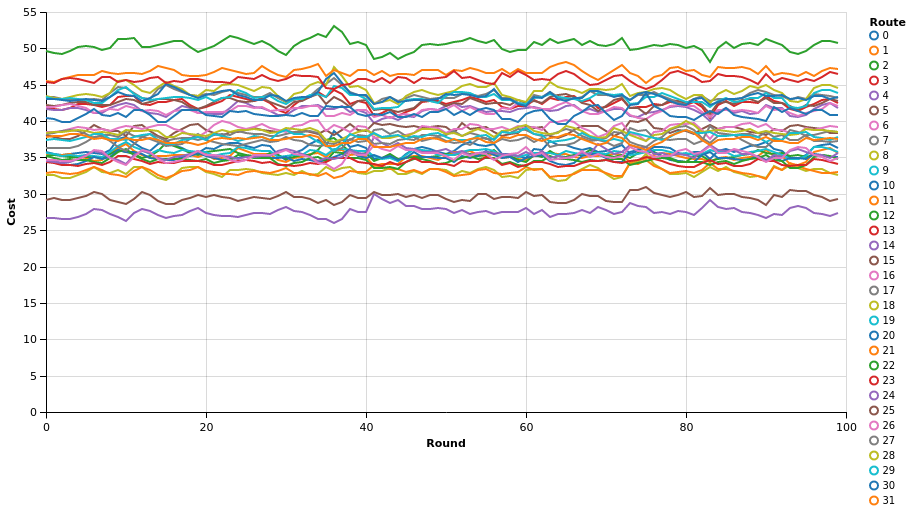

In [9]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='Cost:Q', color='Route:N')
chart.configure_cell(height=400, width=800)

### Total Cost over Time

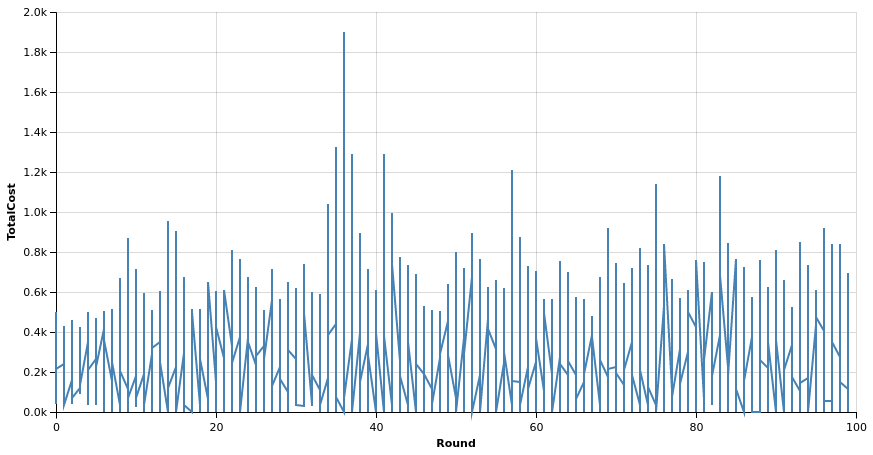

In [10]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='TotalCost:Q')
chart.configure_cell(height=400, width=800)

In [16]:
data_by_routes.sum() # Total cost can get as low as 50

,Count,Cost,TotalCost
Route,,,
0.0,868.0,3615.08,31494.50
1.0,233.0,3518.10,8246.74
2.0,279.0,3539.02,9929.08
3.0,788.0,4244.28,33496.74
4.0,783.0,4147.30,32580.96
5.0,749.0,4248.52,31869.80
6.0,262.0,4151.54,10934.54
7.0,819.0,4347.44,35718.90
8.0,736.0,3303.26,24426.04


### Trpf over Time

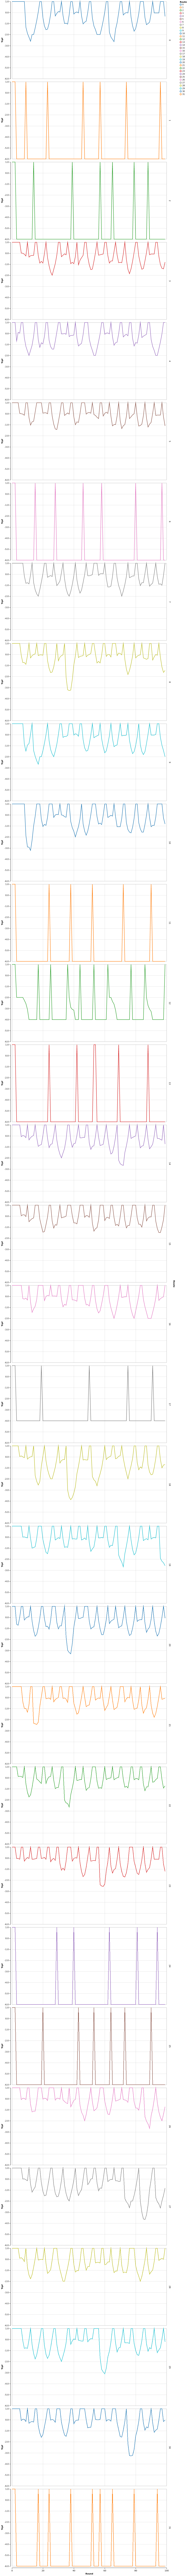

In [11]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='Trpf:Q', color='Route:N', row='Route:N')
chart.configure_cell(height=400, width=800)